In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')

In [3]:
merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [4]:
merged

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
4,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2928480,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928481,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928482,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928483,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


In [5]:
dates = pd.to_datetime(merged['date'], format='%d.%m.%Y')


In [6]:
merged['month'] = dates.apply(lambda x:x.month)

In [11]:
grouped=merged.groupby(['shop_id','item_id','date_block_num']).agg({'item_price':'mean',
                                                                    'item_cnt_day':'sum',
                                                                    'item_category_name':'unique',
                                                                    'month':'unique'})#take some time

In [12]:
grouped=grouped.reset_index()

In [13]:
grouped

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_name,month
0,2,27,0,2499.0,1.0,[Игры - PS3],[1]
1,2,27,17,498.0,1.0,[Игры - PS3],[6]
2,2,30,2,359.0,1.0,[Кино - DVD],[3]
3,2,30,5,399.0,1.0,[Кино - DVD],[6]
4,2,30,15,169.0,1.0,[Кино - DVD],[4]
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,[Кино - Blu-Ray],[4]
1608221,59,22164,30,699.0,1.0,[Кино - Blu-Ray],[7]
1608222,59,22167,9,299.0,1.0,[Книги - Методические материалы 1С],[10]
1608223,59,22167,11,299.0,2.0,[Книги - Методические материалы 1С],[12]


In [14]:
grouped['item_category_name']=grouped['item_category_name'].apply(lambda a:a[0])
grouped['month']=grouped['month'].apply(lambda a:a[0])

In [15]:
grouped=grouped.rename({'item_price':'avg_item_price','item_cnt_day':'item_cnt_month'}, axis='columns')

In [16]:
grouped

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month
0,2,27,0,2499.0,1.0,Игры - PS3,1
1,2,27,17,498.0,1.0,Игры - PS3,6
2,2,30,2,359.0,1.0,Кино - DVD,3
3,2,30,5,399.0,1.0,Кино - DVD,6
4,2,30,15,169.0,1.0,Кино - DVD,4
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12


In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, 'lag')

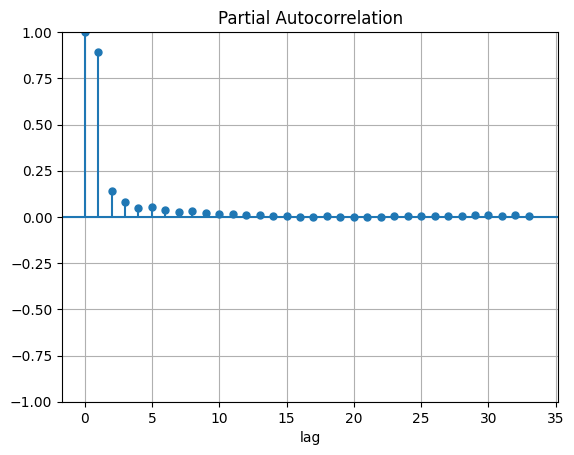

In [42]:
plot_pacf(grouped['avg_item_price'],lags=33)
plt.grid(visible=True)
plt.xlabel('lag')
#items sales have strong relationship with first four lags

Text(0.5, 0, 'lag')

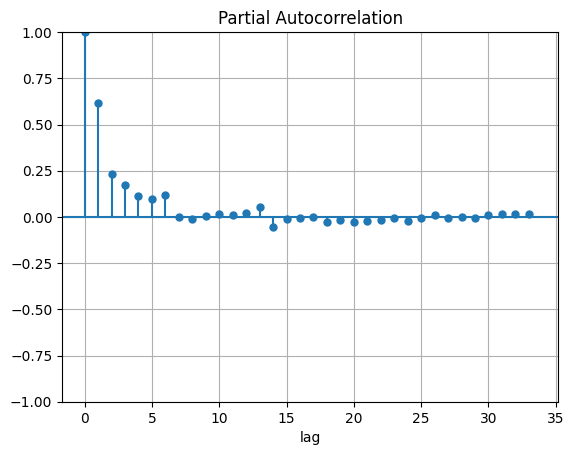

In [41]:
plot_pacf(grouped['item_cnt_month'],lags=33)
plt.grid(visible=True)
plt.xlabel('lag')
#items sales have strong relationship with ;lags 1-6 and 12-14 

In [20]:

def create_lags(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_id']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']+=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']-=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_id']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']+=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']-=lag

        
    return data

In [21]:
#list[(*range(1,15),24])

In [26]:
item_lags=list([*range(1,7),12,13,14,24])
price_lags=list([*range(1,7),12,24])
lagged = create_lags(grouped,item_lags=item_lags,price_lags=price_lags)

In [27]:
lagged.isna().sum()

shop_id                        0
item_id                        0
date_block_num                 0
avg_item_price                 0
item_cnt_month                 0
item_category_name             0
month                          0
item_cnt_month_lag_1      930003
item_cnt_month_lag_2     1014930
item_cnt_month_lag_3     1087510
item_cnt_month_lag_4     1142962
item_cnt_month_lag_5     1189600
item_cnt_month_lag_6     1229430
item_cnt_month_lag_12    1411072
item_cnt_month_lag_13    1434550
item_cnt_month_lag_14    1453122
item_cnt_month_lag_24    1567487
avg_item_price_lag_1      930003
avg_item_price_lag_2     1014930
avg_item_price_lag_3     1087510
avg_item_price_lag_4     1142962
avg_item_price_lag_5     1189600
avg_item_price_lag_6     1229430
avg_item_price_lag_12    1411072
avg_item_price_lag_24    1567487
dtype: int64

<Axes: >

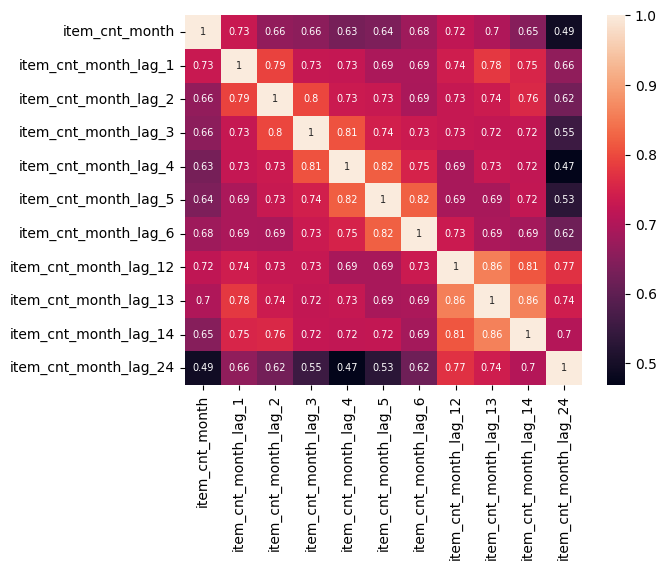

In [38]:
sns.heatmap(lagged[['item_cnt_month',*[f'item_cnt_month_lag_{i}' for i in item_lags]]].corr(),annot=True,annot_kws={'fontsize':7})
#In the potl below we can see, that the more month difference, the less corelation between sales
#Also we can see that monthes 12 and 13 have corellation stronger than previous monthes

<Axes: >

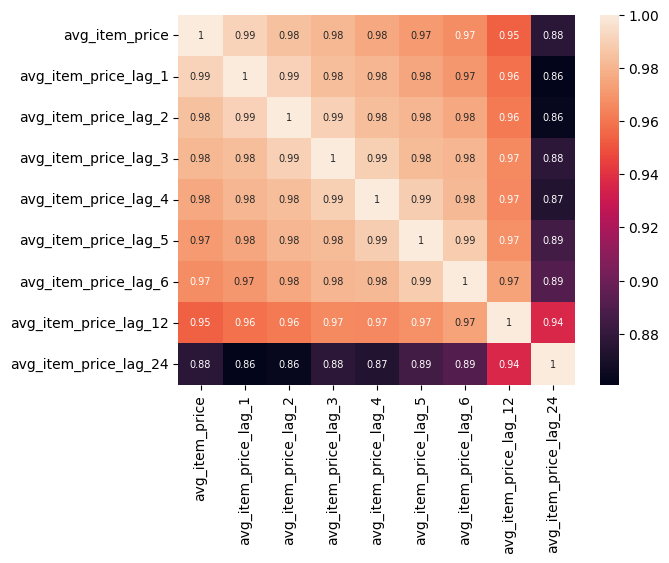

In [29]:
sns.heatmap(lagged[['avg_item_price',*[f'avg_item_price_lag_{i}' for i in price_lags]]].corr(),annot=True,annot_kws={'fontsize':7})
#In the potl below we can see, that the more month difference, the less corelation between prices


Text(0, 0.5, 'item sales')

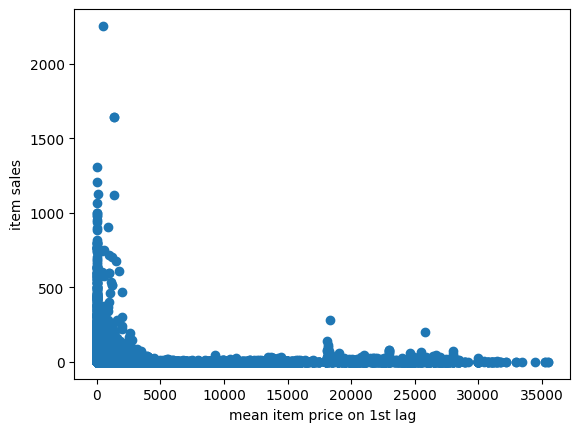

In [40]:

plt.scatter(lagged['avg_item_price_lag_1'],lagged['item_cnt_month'])
plt.xlabel('mean item price on 1st lag')
plt.ylabel('item sales')
#In the plot below we can see, that the lower the price the more sales.

In [31]:
lagged_month = lagged.groupby('month').agg({'item_cnt_month':'sum'}).reset_index()

In [32]:
lagged_month

,month,item_cnt_month
0,1,360391.0
1,2,322775.0
2,3,345171.0
3,4,282131.0
4,5,277519.0
5,6,287443.0
6,7,271985.0
7,8,294692.0
8,9,305967.0
9,10,306622.0


Text(0.5, 0, 'month')

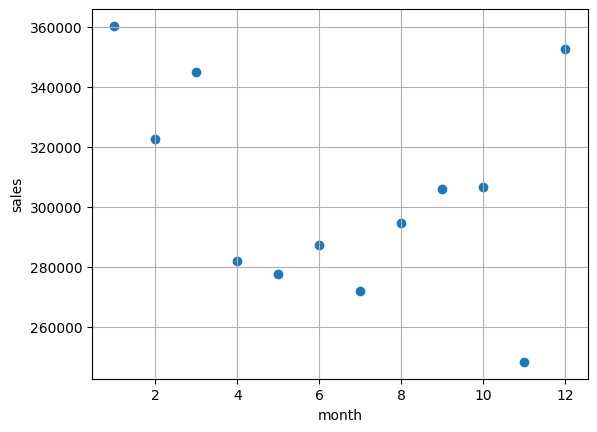

In [39]:

plt.scatter(lagged_month['month'],lagged_month['item_cnt_month'])
plt.grid(True)
plt.ylabel('sales')
plt.xlabel('month')
#In the plot below we can see, that different monthes have different sales, and this difference reaches 44% (1st and 11th monthes)